In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ETFunctions as ET
%matplotlib inline
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

In [2]:
Data = pd.read_pickle('.\DataFrames\TempAndRadnCleaned.pkl')

### Wind speed data looks OK now, 

## Calculate hourly temperatures values and graph

<AxesSubplot:>

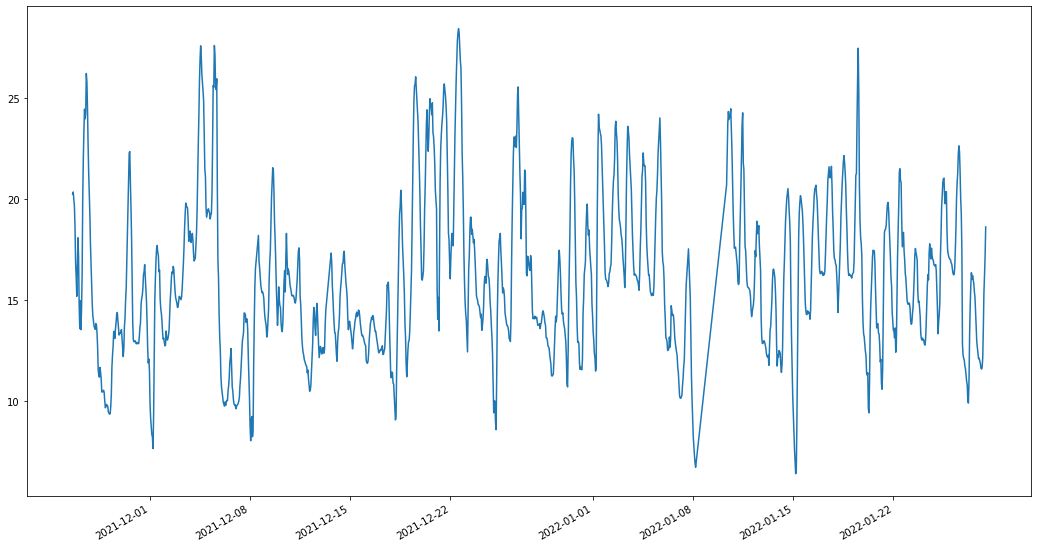

In [3]:
HourlyTemperature = Data['AirTemperature'].resample('h').mean() #convert more frequent data to hourly means
HourlyTemperature.where(HourlyTemperature>-20,np.nan,inplace=True)  #convert errant data to nan
HourlyTemperature.dropna(inplace=True)                              #remove dates with nan data
HourlyTemperature = HourlyTemperature.squeeze()                     #remove column dymension (i.e convert dataframe to series)
HourlyTemperature.plot(figsize=(18,10))

In [4]:
HourlyTemperature.name = 'AirTemp'

<AxesSubplot:>

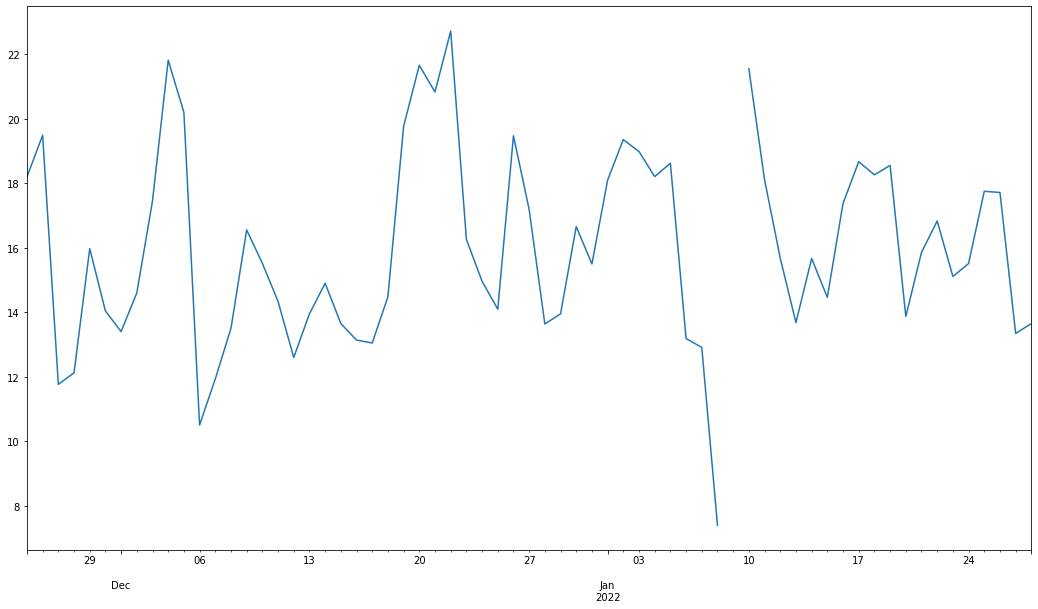

In [5]:
DailyMeanTemp = HourlyTemperature.resample('D').mean()
DailyMeanTemp.plot(figsize=(18,10))

<AxesSubplot:>

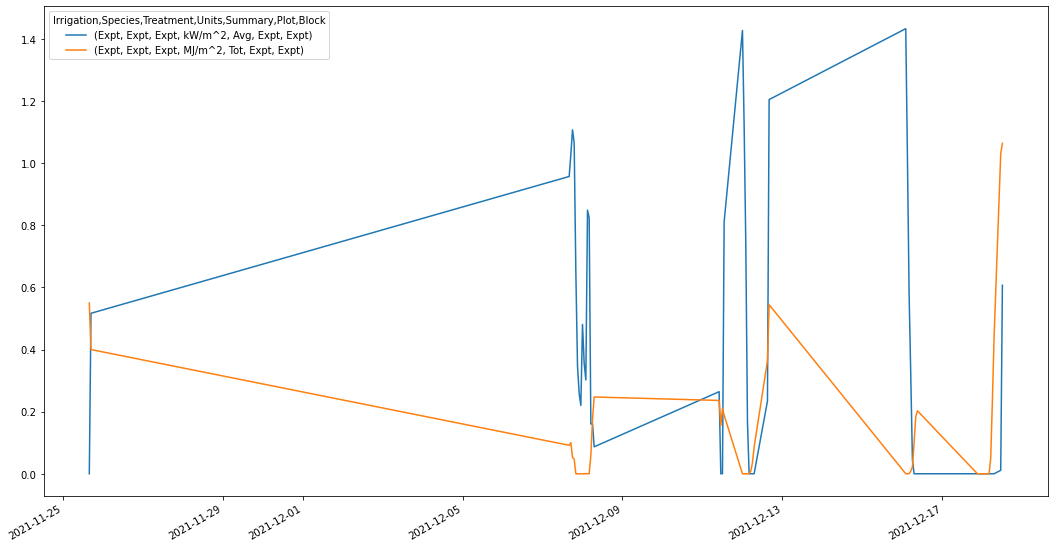

In [6]:
HourlyRadiation = Data['IncomingRadnKW'].resample('h').mean()
HourlyRadiation.where(HourlyRadiation>-20,np.nan,inplace=True)  #convert errant data to nan
HourlyRadiation.dropna(inplace=True)                              #remove dates with nan data
HourlyRadiation = HourlyRadiation.squeeze()                     #remove column dymension (i.e convert dataframe to series)
HourlyRadiation.plot(figsize=(18,10))

In [7]:
HourlyRadiation.name = 'Radn'

<AxesSubplot:>

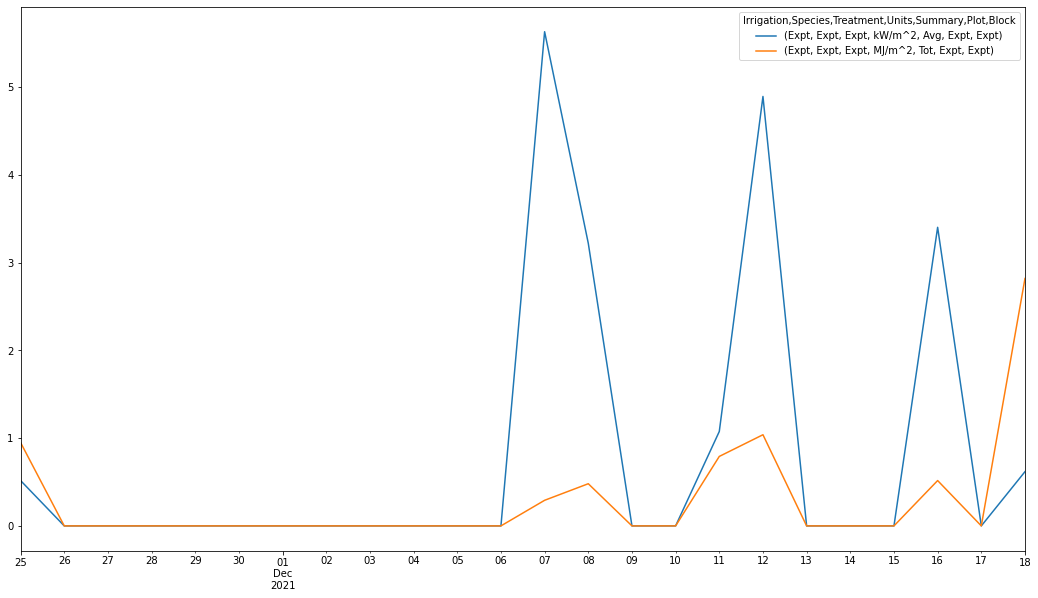

In [8]:
DailyRadiation = HourlyRadiation.resample('D').sum()
DailyRadiation.plot(figsize=(18,10))

<AxesSubplot:>

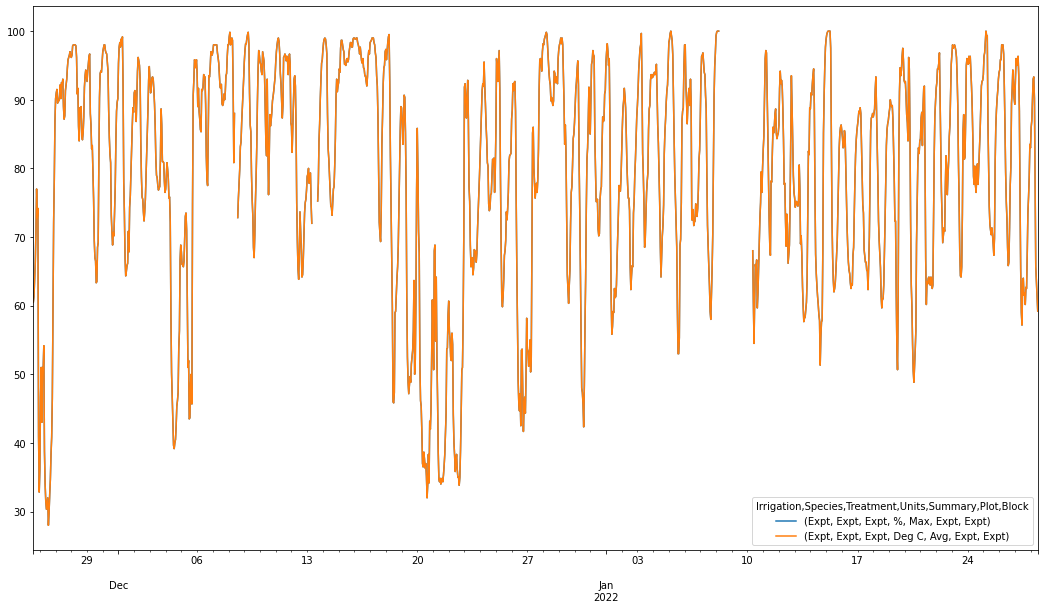

In [9]:
HourlyHumidity = Data['RelativeHumidity'].resample('h').mean()
HourlyHumidity.plot(figsize=(18,10))

<AxesSubplot:>

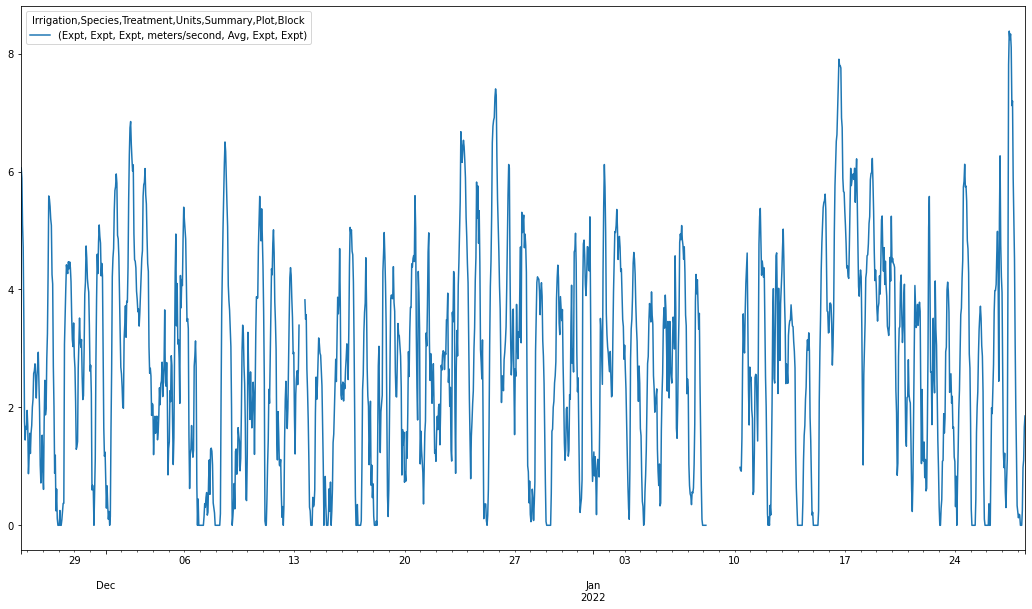

In [10]:
HourlyHumidity = Data['Windspeed'].resample('h').mean()
HourlyHumidity.plot(figsize=(18,10))

In [11]:
HourlyMetData = pd.DataFrame(index = Data.loc[:,:].resample('h').mean().index)
HourlyMetData.loc[:,'AirTemperature'] = Data.loc[:,'AirTemperature'].resample('h').mean()
HourlyMetData.loc[:,'IncomingRadnMJ'] = Data.loc[:,'IncomingRadnMJ'].resample('h').sum()
HourlyMetData.loc[:,'Rainfall'] = Data.loc[:,'Rainfall'].resample('h').sum()
HourlyMetData.loc[:,'RelativeHumidity'] = Data.loc[:,'RelativeHumidity'].resample('h').sum()
HourlyMetData.loc[:,'Windspeed'] = Data.loc[:,'Windspeed'].resample('h').mean()

<AxesSubplot:>

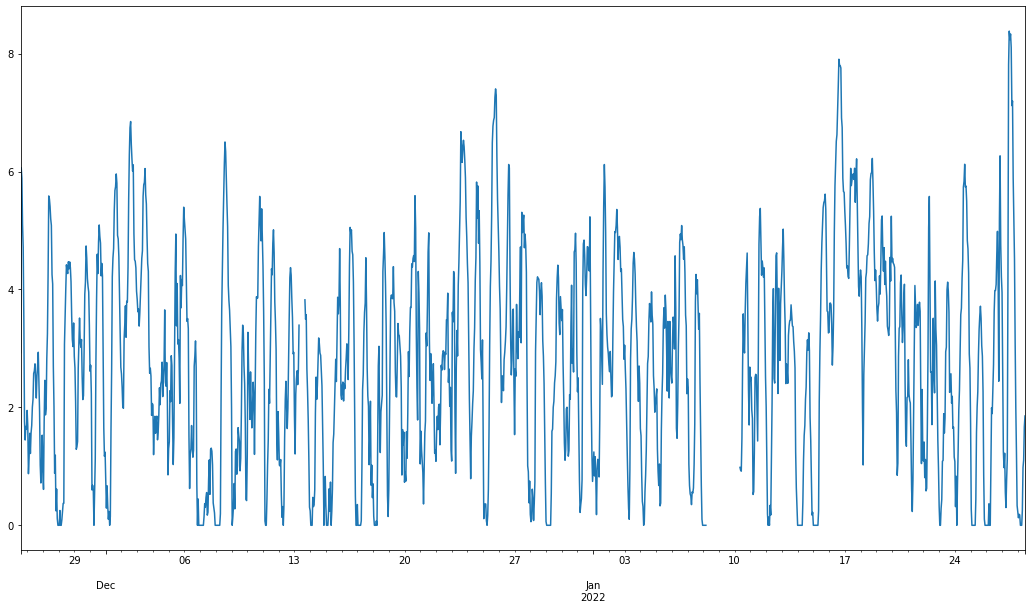

In [12]:
HourlyMetData.loc[:,'Windspeed'].plot(figsize=(18,10))

### For some reason the logger has not zeroed windspeeds below 0.36 so we need to impose this here

In [18]:
Start = HourlyMetData.index.min()
End = HourlyMetData.index.max()
BroadFieldsMet = pd.read_pickle('C:\GitHubRepos\Weather\Broadfields\BroadFieldsMet.pkl')
BroadFieldsHourly = BroadFieldsMet.loc[Start:End,:].resample('h').mean()
BroadFieldsHourly.loc[:,'IncomingRadnMJ'] = BroadFieldsMet.loc[Start:End,'IncomingRadnMJ'].resample('h').sum()
BroadFieldsHourly.loc[:,'Rainfall'] = BroadFieldsMet.loc[Start:End,'Rainfall'].resample('h').sum()
BroadFieldsHourly.to_pickle('.\DataFrames\BroadFieldsHourly.pkl')

In [19]:
BroadFieldsDaily = BroadFieldsMet.resample('d').mean()
BroadFieldsDaily.loc[:,'IncomingRadnMJ'] = BroadFieldsMet.loc[:,'IncomingRadnMJ'].resample('d').sum()
BroadFieldsDaily.loc[:,'Rainfall'] = BroadFieldsMet.loc[:,'Rainfall'].resample('d').sum()
BroadFieldsDaily.to_pickle('.\DataFrames\BroadFieldsDaily.pkl')

In [20]:
def MakeComparePlot(Figure, Variable,pos):
    ax = Figure.add_subplot(5,1,pos)
    xData = HourlyMetData.loc[:,Variable]
    yData = BroadFieldsHourly.loc[HourlyMetData.loc[:,Variable].index,Variable]
    plt.plot(xData,
             yData,
            'o')
    ModTemp = sm.regression.linear_model.OLS(yData,  # Y variable
                                            sm.add_constant(xData), # X variable
                                            missing='drop',                                     # ignor and data where one value is missing
                                            hasconst=False) 
    Regres = ModTemp.fit(); 
    Xs = []
    Xs.append(xData.min())
    Xs.append(xData.max())
    Ys = []
    Ys.append(Regres.params[0] + Xs[0]*Regres.params[1])
    Ys.append(Regres.params[0] + Xs[1]*Regres.params[1])
    plt.plot(Xs,Ys,'-', linewidth = 4, color='k')
    fitR2 = 'R^2 = ' + str(Regres.rsquared)[:4] + '\n Int = ' + str(Regres.params[0])[:7] + '\n Slope = ' + str(Regres.params[1])[:7]
    plt.text(.05,0.8,fitR2,fontsize=20,transform=ax.transAxes)
    plt.title(Variable)

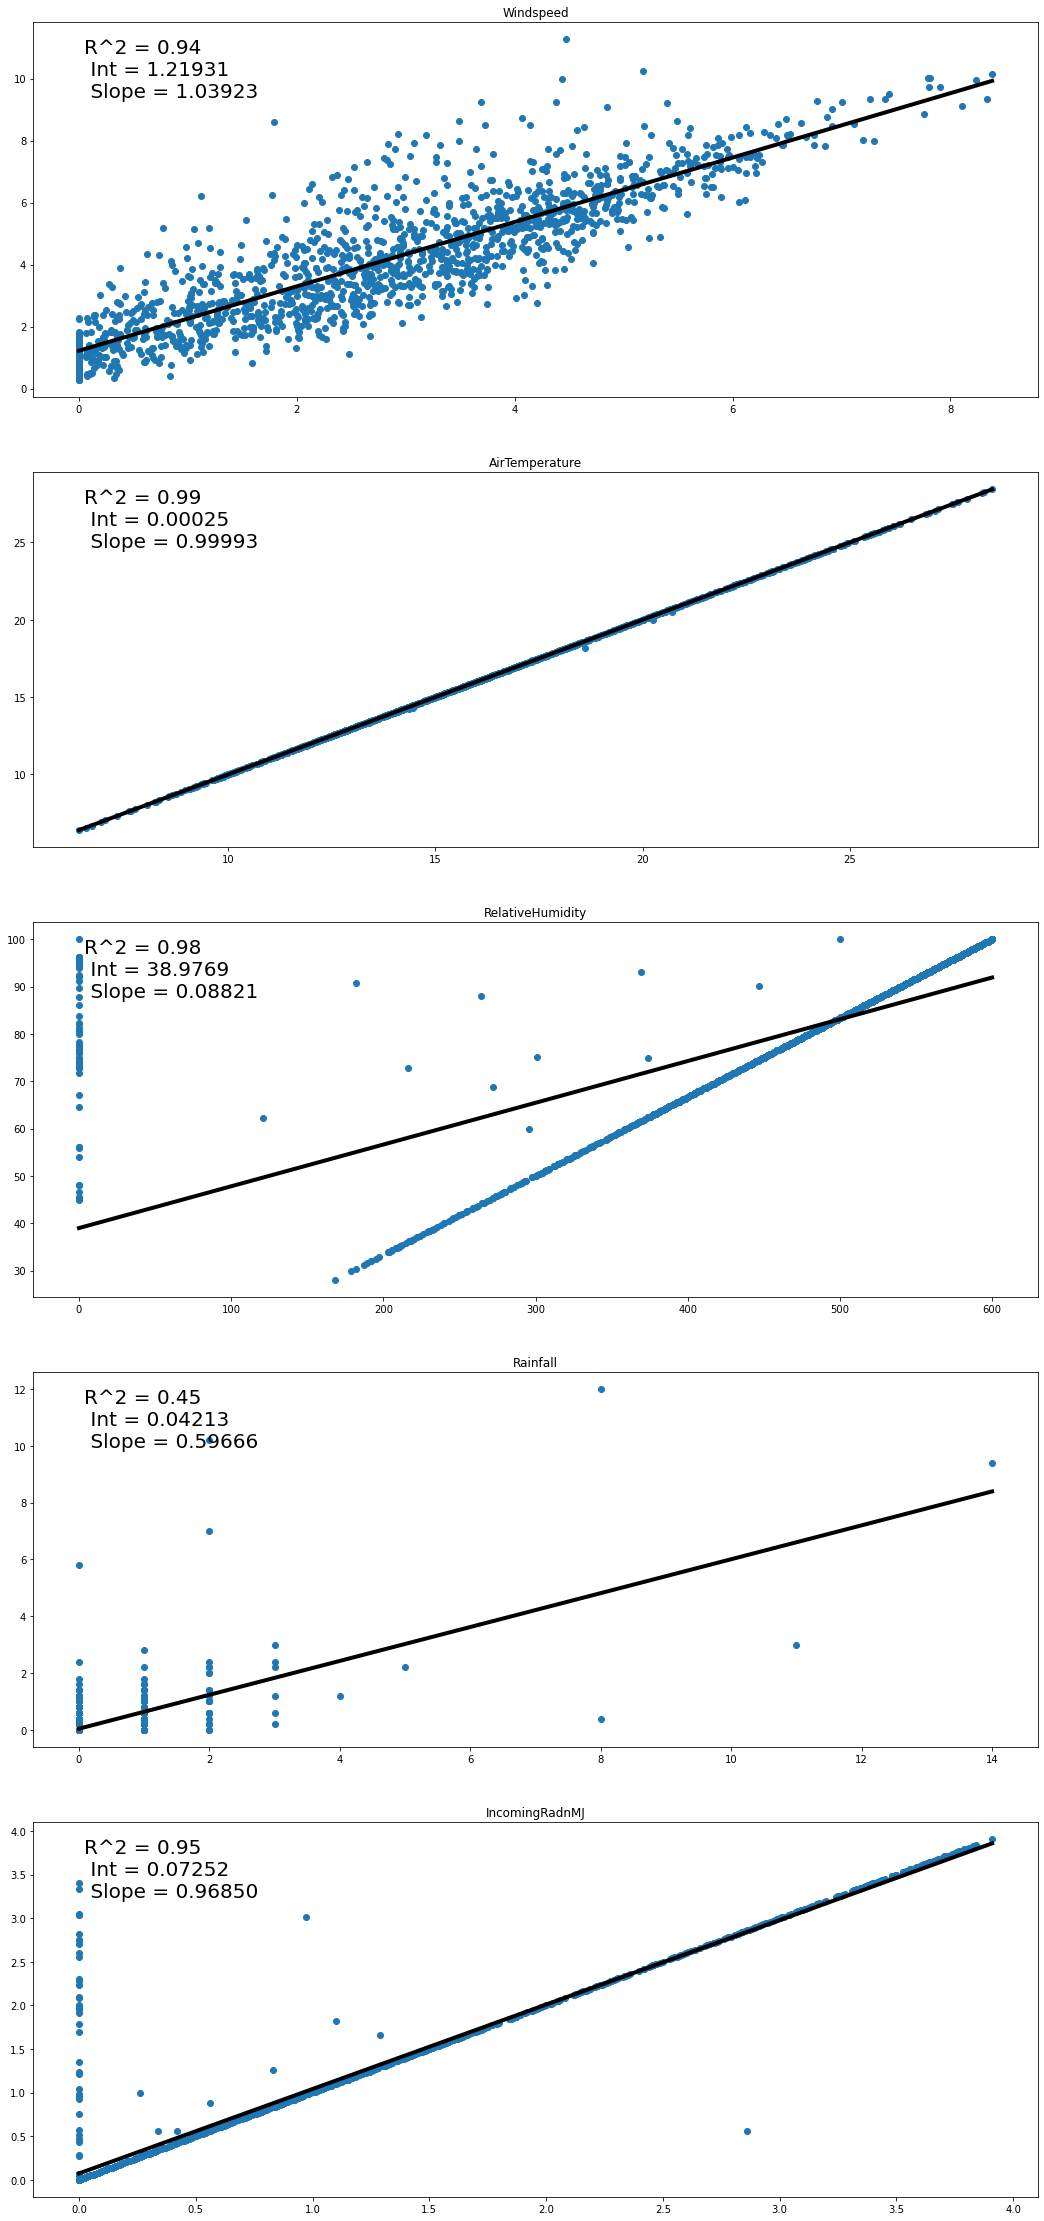

In [21]:
Variables = ['Windspeed','AirTemperature','RelativeHumidity','Rainfall','IncomingRadnMJ']
Figure = plt.figure(figsize=(18,40))
pos = 1
for Variable in Variables:
    MakeComparePlot(Figure,Variable,pos)
    pos +=1

## Data all looks fine relative to broadfield station
Air temp, humidity, wind and rainfall are mostly correlated but differnt position relative to shelter belt would mean they should not be perfectly correlated.  Radiation is the same for both because Broadfields data used for both data frames

In [ ]:
HourlyMetData.to_pickle('.\DataFrames\HourlyMet.pkl')